# UN General Assembly Voting Patterns: Clustering Analysis 

## Objectives
1. Apply K-means clustering to real-world data
2. Apply hierarchical clustering to real-world data
3. Compare different clustering methods and interpret their results
4. Validate clustering results using appropriate metrics
5. Interpret clustering results in a meaningful real-world context

## Dataset Overview
UN General Assembly voting patterns from 1946-2019. The dataset contains:
- **869,937 individual votes** from 200 countries
- **6,202 resolutions** across various topics
- **Vote types:** Yes, No, Abstain

The goal is to identify voting blocs: groups of countries that tend to vote similarly on UN resolutions.

## Part 1: Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set plotting parameters
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Load the datasets

votes_df = pd.read_csv('unvotes.csv')
roll_calls_df = pd.read_csv('roll_calls.csv')
issues_df = pd.read_csv('issues.csv')

print("Dataset Information:")
print(f"Votes dataset: {votes_df.shape}")
print(f"Roll calls dataset: {roll_calls_df.shape}")
print(f"Issues dataset: {issues_df.shape}")

print("\nFirst few rows of votes dataset:")
print(votes_df.head())

print("\nVote distribution:")
print(votes_df['vote'].value_counts())

Dataset Information:
Votes dataset: (869937, 4)
Roll calls dataset: (6202, 9)
Issues dataset: (5745, 3)

First few rows of votes dataset:
   rcid             country country_code vote
0     3       United States           US  yes
1     3              Canada           CA   no
2     3                Cuba           CU  yes
3     3               Haiti           HT  yes
4     3  Dominican Republic           DO  yes

Vote distribution:
vote
yes        693544
abstain    110893
no          65500
Name: count, dtype: int64


## Part 2: Data Preprocessing

In [3]:
# Step 1: Encode votes numerically
print("Step 1: Encoding votes numerically...")
vote_encoding = {'yes': 1, 'abstain': 0, 'no': -1}
votes_df['vote_numeric'] = votes_df['vote'].map(vote_encoding)

print("Vote encoding:")
for vote, code in vote_encoding.items():
    print(f"  {vote} → {code}")

Step 1: Encoding votes numerically...
Vote encoding:
  yes → 1
  abstain → 0
  no → -1


In [4]:
# Step 2: Create country-resolution voting matrix
print("Step 2: Creating voting matrix...")

# Pivot table: countries as rows, resolutions as columns
voting_matrix = votes_df.pivot_table(
    index='country',
    columns='rcid',
    values='vote_numeric',
    fill_value=np.nan
)

print(f"Voting matrix shape: {voting_matrix.shape}")
print(f"Countries: {voting_matrix.shape[0]}")
print(f"Resolutions: {voting_matrix.shape[1]}")

# Check missing data
missing_count = voting_matrix.isnull().sum().sum()
total_cells = voting_matrix.size
missing_percentage = (missing_count / total_cells) * 100

print(f"\nMissing values: {missing_count:,} ({missing_percentage:.1f}% of total data)")

Step 2: Creating voting matrix...
Voting matrix shape: (200, 6202)
Countries: 200
Resolutions: 6202

Missing values: 370,463 (29.9% of total data)


In [5]:
# Step 3: Filter countries and resolutions with low participation
print("Step 3: Filtering data for quality...")

# Set minimum participation threshold
min_participation = 0.5  # 50%

# Filter countries with low participation
country_participation = voting_matrix.notna().sum(axis=1) / voting_matrix.shape[1]
active_countries = country_participation[country_participation >= min_participation].index
voting_matrix_filtered = voting_matrix.loc[active_countries]

print(f"Countries after filtering: {len(active_countries)} (removed {voting_matrix.shape[0] - len(active_countries)})")

# Filter resolutions with low participation
resolution_participation = voting_matrix_filtered.notna().sum(axis=0) / voting_matrix_filtered.shape[0]
active_resolutions = resolution_participation[resolution_participation >= min_participation].index
voting_matrix_clean = voting_matrix_filtered[active_resolutions]

print(f"Resolutions after filtering: {len(active_resolutions)} (removed {voting_matrix_filtered.shape[1] - len(active_resolutions)})")

# Fill remaining missing values with 0 (abstain)
voting_matrix_final = voting_matrix_clean.fillna(0)

print(f"\nFinal dataset shape: {voting_matrix_final.shape}")
print(f"Remaining missing values: {voting_matrix_final.isnull().sum().sum()}")

print("\nData preprocessing completed!")

Step 3: Filtering data for quality...
Countries after filtering: 148 (removed 52)
Resolutions after filtering: 5702 (removed 500)

Final dataset shape: (148, 5702)
Remaining missing values: 0

Data preprocessing completed!


In [ ]:
#Step 4: Additional preprocessing steps here
print("\nStep 4: Additional preprocessing...")

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(voting_matrix_final)

print("Data standardized successfully!")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)   # keep 95% variance
data_pca = pca.fit_transform(data_scaled)

print(f"PCA completed! Reduced dimensions: {data_pca.shape[1]}")
print(f"Explained variance ratio (sum): {pca.explained_variance_ratio_.sum():.3f}")

# Convert PCA result back into a DataFrame
data_for_clustering = pd.DataFrame(
    data_pca,
    index=voting_matrix_final.index,
    columns=[f'PC{i+1}' for i in range(data_pca.shape[1])]
)

print("\nFinal preprocessed dataset ready for clustering!")
print(f"Shape: {data_for_clustering.shape}")


Step 4: Additional preprocessing...
Data standardized successfully!
PCA completed! Reduced dimensions: 104
Explained variance ratio (sum): 0.951

Final preprocessed dataset ready for clustering!
Shape: (148, 104)


## Part 3: K-means Clustering

In [7]:
# Step 1: Determine optimal number of clusters
print("Finding optimal number of clusters for K-means...")

# Test different values of k
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    # Create and fit K-means model with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Fit the model and get predictions
    labels = kmeans.fit_predict(data_for_clustering)

    # Store inertia
    inertias.append(kmeans.inertia_)

    # Calculate silhouette score
    sil_score = silhouette_score(data_for_clustering, labels)
    silhouette_scores.append(sil_score)

    print(f"k={k}: inertia={kmeans.inertia_:.0f}, silhouette={sil_score:.3f}")


Finding optimal number of clusters for K-means...
k=2: inertia=646528, silhouette=0.304
k=3: inertia=610755, silhouette=0.214
k=4: inertia=560643, silhouette=0.220
k=5: inertia=535266, silhouette=0.108
k=6: inertia=490749, silhouette=0.123
k=7: inertia=484308, silhouette=0.120
k=8: inertia=476302, silhouette=0.103
k=9: inertia=467685, silhouette=0.083
k=10: inertia=456935, silhouette=0.083


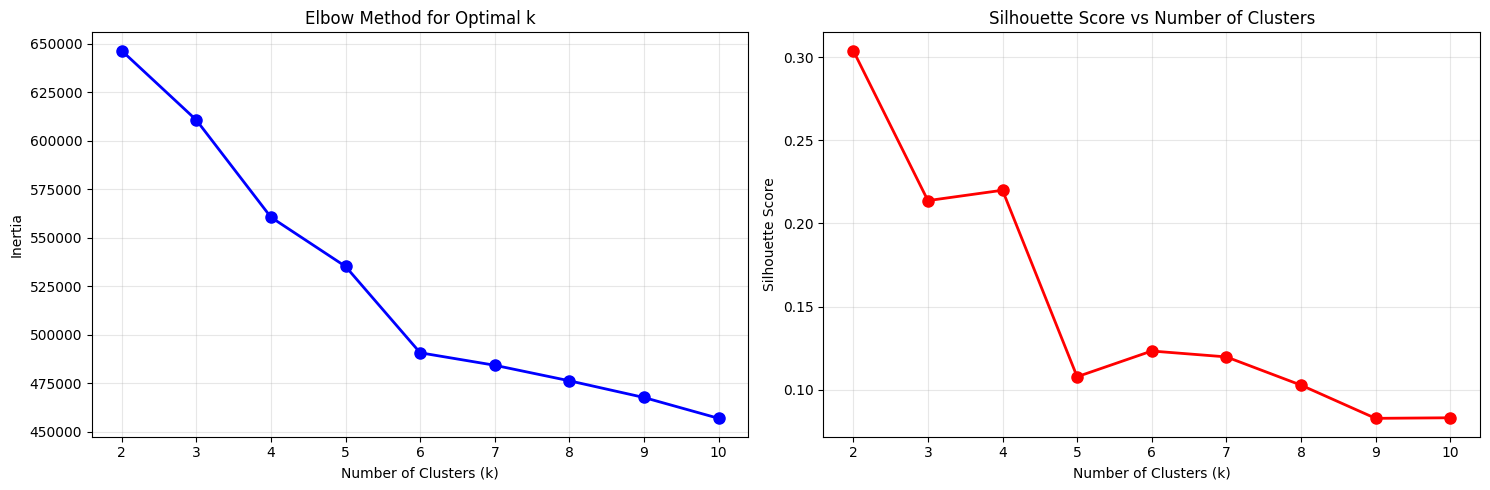


Chosen optimal k: 2
Reasoning: The silhouette score reached its highest value at k=2 (0.304), which is significantly higher than all other k values. Scores for k ≥ 3 dropped sharply and stayed low, indicating weaker separation between clusters. Although the inertia decreases gradually with larger k, the elbow is not very pronounced beyond k=2. Therefore, k=2 provides the best balance of compact and well-separated clusters.


In [ ]:
# Plot the results to help choose optimal k
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)

# Silhouette plot
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# choose your optimal k
optimal_k = 2 

print(f"\nChosen optimal k: {optimal_k}")
print("Reasoning: The silhouette score reached its highest value at k=2 (0.304), which is significantly higher than all other k values. Scores for k ≥ 3 dropped sharply and stayed low, indicating weaker separation between clusters. Although the inertia decreases gradually with larger k, the elbow is not very pronounced beyond k=2. Therefore, k=2 provides the best balance of compact and well-separated clusters.")


In [9]:
# Step 2: Apply K-means with optimal k
print(f"Applying K-means clustering with k={optimal_k}...")

# Create and fit the final K-means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans_final.fit_predict(data_for_clustering)

# Create results dataframe
kmeans_results = pd.DataFrame({
    'country': data_for_clustering.index,
    'cluster': kmeans_labels
})

print("\nK-means cluster sizes:")
cluster_sizes = kmeans_results['cluster'].value_counts().sort_index()
print(cluster_sizes)

print("\nSample countries in each cluster:")
for cluster in range(optimal_k):
    cluster_countries = kmeans_results[kmeans_results['cluster'] == cluster]['country'].tolist()
    print(f"Cluster {cluster}: {cluster_countries[:10]}{'...' if len(cluster_countries) > 10 else ''}")


Applying K-means clustering with k=2...

K-means cluster sizes:
cluster
0    124
1     24
Name: count, dtype: int64

Sample countries in each cluster:
Cluster 0: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua & Barbuda', 'Argentina', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados']...
Cluster 1: ['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland', 'France', 'Greece', 'Iceland', 'Ireland']...


## Part 4: Hierarchical Clustering

**Instructions:** Complete the hierarchical clustering analysis.

In [11]:
# Apply hierarchical clustering with the same number of clusters as K-means
print(f"Applying Hierarchical clustering with k={optimal_k}...")

# Create and fit hierarchical clustering model
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(data_for_clustering)

# Create results dataframe
hierarchical_results = pd.DataFrame({
    'country': data_for_clustering.index,
    'cluster': hierarchical_labels
})

print("\nHierarchical cluster sizes:")
cluster_sizes = hierarchical_results['cluster'].value_counts().sort_index()
print(cluster_sizes)

print("\nSample countries in each cluster:")
for cluster in range(optimal_k):
    cluster_countries = hierarchical_results[hierarchical_results['cluster'] == cluster]['country'].tolist()
    print(f"Cluster {cluster}: {cluster_countries[:10]}{'...' if len(cluster_countries) > 10 else ''}")


Applying Hierarchical clustering with k=2...

Hierarchical cluster sizes:
cluster
0     25
1    123
Name: count, dtype: int64

Sample countries in each cluster:
Cluster 0: ['Australia', 'Austria', 'Belgium', 'Canada', 'Cyprus', 'Denmark', 'Finland', 'France', 'Greece', 'Iceland']...
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua & Barbuda', 'Argentina', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados']...


Creating dendrogram...


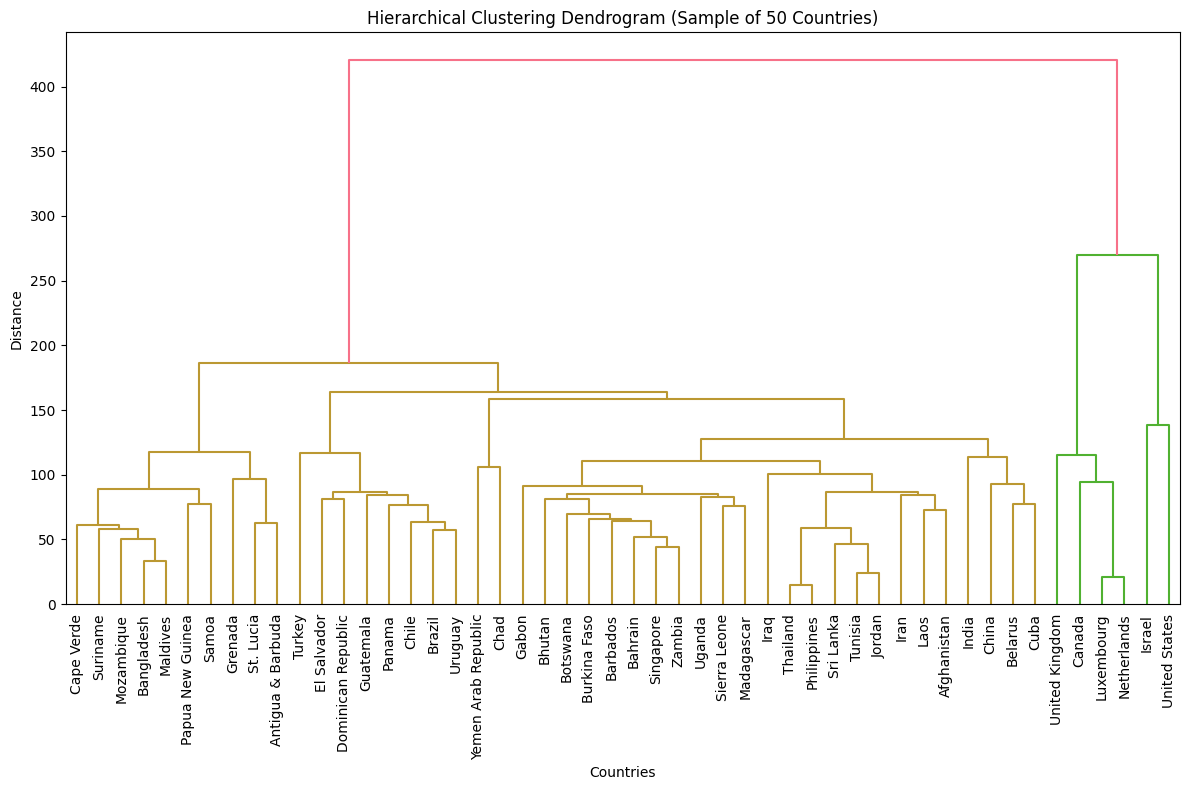

In [12]:
# Create a dendrogram for hierarchical clustering (using a sample of countries)
print("Creating dendrogram...")

# Use a sample for visualization (dendrograms become unreadable with too many items)
sample_size = 50
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(len(data_for_clustering), sample_size, replace=False)
sample_data = data_for_clustering.iloc[sample_indices]
sample_countries = data_for_clustering.index[sample_indices]

# Calculate linkage matrix
linkage_matrix = linkage(sample_data, method='ward')  # Ward's method is common for numerical PCA data

# Create dendrogram
dendrogram(
    linkage_matrix,
    labels=sample_countries,
    leaf_rotation=90,  # rotate country names for readability
    leaf_font_size=10,
    color_threshold=None  # optional: automatically color clusters
)

plt.title(f'Hierarchical Clustering Dendrogram (Sample of {sample_size} Countries)')
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


## Part 5: Comparison of Clustering Methods

In [13]:
# Calculate and compare performance metrics
print("Comparing clustering methods...")

# Calculate silhouette scores for both methods
kmeans_silhouette = silhouette_score(data_for_clustering, kmeans_labels)
hierarchical_silhouette = silhouette_score(data_for_clustering, hierarchical_labels)

print(f"\nSilhouette Scores:")
print(f"K-means: {kmeans_silhouette:.3f}")
print(f"Hierarchical: {hierarchical_silhouette:.3f}")

# Calculate agreement between methods using Adjusted Rand Index
agreement = adjusted_rand_score(kmeans_labels, hierarchical_labels)

print(f"\nAgreement between methods (Adjusted Rand Index): {agreement:.3f}")
print(f"Interpretation: {'High' if agreement > 0.7 else 'Moderate' if agreement > 0.4 else 'Low'} agreement")


Comparing clustering methods...

Silhouette Scores:
K-means: 0.304
Hierarchical: 0.282

Agreement between methods (Adjusted Rand Index): 0.900
Interpretation: High agreement


## Part 6: PCA and Visualization

Apply PCA for dimensionality reduction and create visualizations of your clustering results.

In [ ]:
# Apply PCA for visualization

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_for_clustering)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

PCA explained variance ratio: [0.2458353  0.09880912]
Total variance explained: 0.345


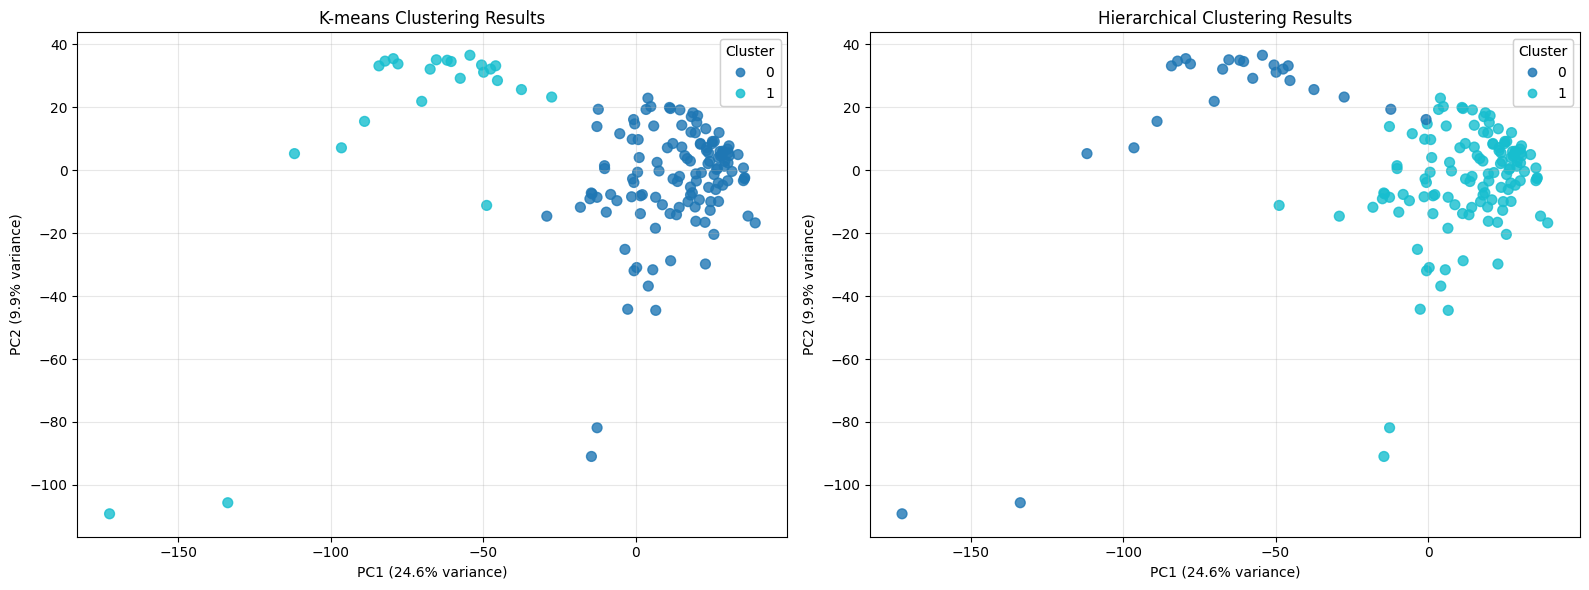

In [24]:
# Create visualization comparing both clustering methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot K-means results
scatter1 = ax1.scatter(
    data_pca[:, 0], 
    data_pca[:, 1], 
    c=kmeans_labels, 
    cmap='tab10', 
    s=50, 
    alpha=0.8
)
ax1.set_title('K-means Clustering Results')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.grid(True, alpha=0.3)
legend1 = ax1.legend(*scatter1.legend_elements(), title="Cluster")
ax1.add_artist(legend1)

# Plot Hierarchical results
scatter2 = ax2.scatter(
    data_pca[:, 0], 
    data_pca[:, 1], 
    c=hierarchical_labels, 
    cmap='tab10', 
    s=50, 
    alpha=0.8
)
ax2.set_title('Hierarchical Clustering Results')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax2.grid(True, alpha=0.3)
legend2 = ax2.legend(*scatter2.legend_elements(), title="Cluster")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()


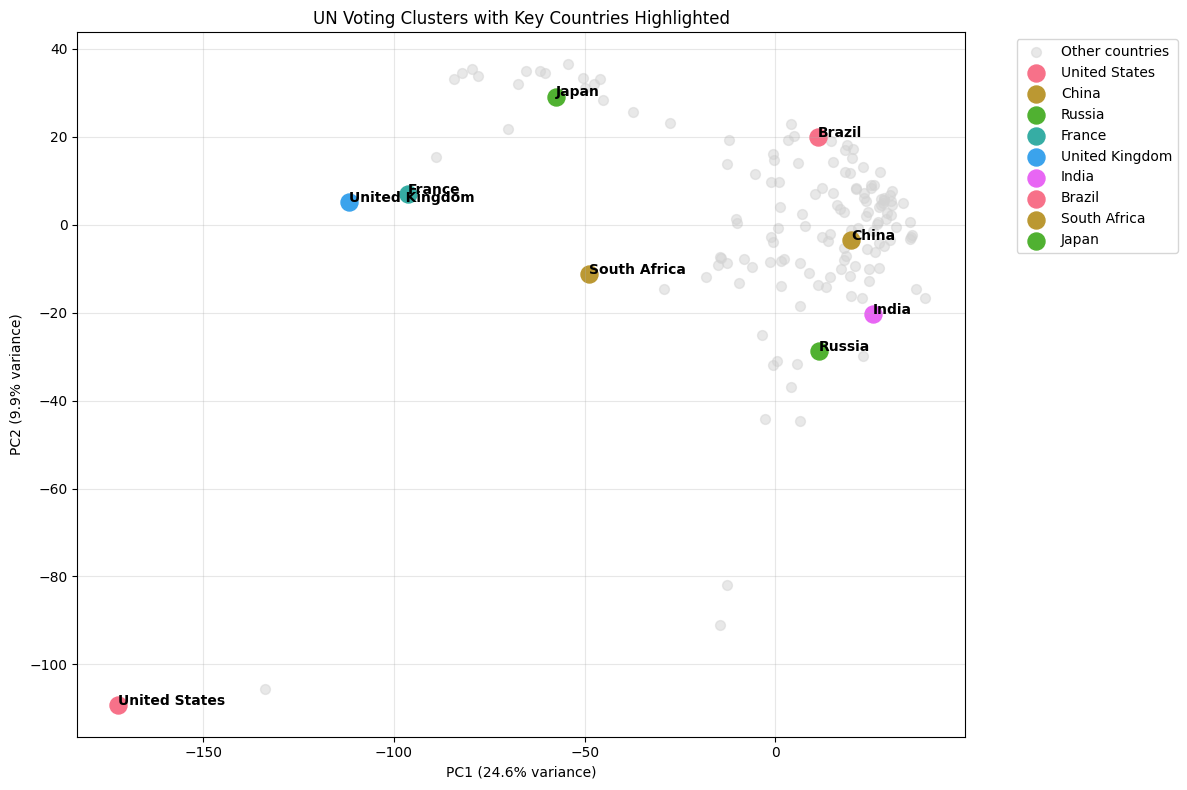

In [25]:
# Create a more detailed visualization highlighting key countries
plt.figure(figsize=(12, 8))

# Plot all countries in light gray as background
plt.scatter(
    data_pca[:, 0], 
    data_pca[:, 1], 
    c='lightgray', 
    s=50, 
    alpha=0.5,
    label='Other countries'
)

# Highlight key countries
key_countries = ['United States', 'China', 'Russia', 'France', 'United Kingdom', 
                 'India', 'Germany', 'Brazil', 'South Africa', 'Japan']

for country in key_countries:
    if country in data_for_clustering.index:
        idx = data_for_clustering.index.get_loc(country)
        plt.scatter(
            data_pca[idx, 0],
            data_pca[idx, 1],
            s=150,
            label=country
        )
        plt.text(
            data_pca[idx, 0]+0.02, 
            data_pca[idx, 1]+0.02, 
            country, 
            fontsize=10, 
            fontweight='bold'
        )

plt.title('UN Voting Clusters with Key Countries Highlighted')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
